# Munge Available Data

This notebook just creates a nice dictionary of data for us to use later.

In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import OrderedDict
import pandas as pd

# Basic Parameters

In [2]:
period_est0, t0_est0, dur_est0 = 4.0552941, 2455342.96913, 0.1
M_star = 0.913, 0.047
R_star = 0.939, 0.022
# Around 90 earth mass
msini=90

# Load the data

In [3]:
# I'm not correcting for HJD to BJD...
rv_df = pd.concat([pd.read_csv('data/faedi.csv'), pd.read_csv('data/mancini.csv')]).reset_index(drop=True)
def clean_df(df):
    df['dmag'] = np.asarray([d.strip() for d in np.asarray(df.dmag)], float)
    df['e_dmag'] = np.asarray([d.strip() for d in np.asarray(df.e_dmag)], float)
    df['HJD'] = np.asarray([d.strip() for d in np.asarray(df.HJD)], float)
    df['flux'] = (10**(df.dmag/-2.5))
    df['flux_err'] = (np.log(10) * df.e_dmag/2.5) * df['flux']
    return df
wasp_df = clean_df(pd.read_csv('data/wasp-39.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
euler_df = clean_df(pd.read_csv('data/faedi_transit.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
FTN_df = clean_df(pd.read_csv('data/faedi_transit2.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
ricci_df = pd.read_csv('data/ricci_transit.csv')
ricci_df = ricci_df[(ricci_df.Filt == 'I')]# | (ricci_df.Filt == 'I')]
wfc3_df = pd.read_csv('data/WASP-39_transit_WFC3 (1).csv')
jwst_df = pd.read_csv('data/WASP-39_JWST.csv')
irac1_df = pd.read_csv('data/WASP-39_SpitzerIRAC1.csv')
irac2_df = pd.read_csv('data/WASP-39_SpitzerIRAC2.csv')

In [4]:
# Loading them into lightkurve for some niceties, not required though!
wasp_lc =lk.LightCurve(time=wasp_df.HJD, flux=wasp_df.flux, flux_err=wasp_df.flux_err)
wasp_lc = wasp_lc[np.unique(wasp_lc.time.value, return_inverse=True)[1]]
euler_lc = lk.LightCurve(time=euler_df.HJD, flux=euler_df.flux, flux_err=euler_df.flux_err)
FTN_lc = lk.LightCurve(time=FTN_df.HJD, flux=FTN_df.flux, flux_err=FTN_df.flux_err)
ricci_lc = lk.LightCurve(time=ricci_df.BJD, flux=ricci_df.Flux)
ricci_flc = ricci_lc.fold(4.0552941, 2455342.96913)
ricci_lc.flux_err = np.ones(len(ricci_lc)) * ricci_flc[np.abs(ricci_flc.time.value) > 0.06].flux.std()
wfc3_lc = lk.LightCurve(time=wfc3_df.BJD, flux=wfc3_df.flux, flux_err=wfc3_df.flux_err)
jwst_lc = lk.LightCurve(time=jwst_df.BJD, flux=jwst_df.flux, flux_err=jwst_df.flux_err)[300:]
irac1_lc = lk.LightCurve(time=irac1_df.BJD, flux=irac1_df.flux, flux_err=irac1_df.flux_err)
irac2_lc = lk.LightCurve(time=irac2_df.BJD, flux=irac2_df.flux, flux_err=irac2_df.flux_err)
tess_lc = lk.read('data/WASP-39b_TESS_Sector51_CorrectedLC.fits').normalize()
tess_lc.time.jd = tess_lc.time + 2457000
tess_lc.time.format = 'jd'

<AxesSubplot:xlabel='Time [JD]', ylabel='Normalized Flux'>

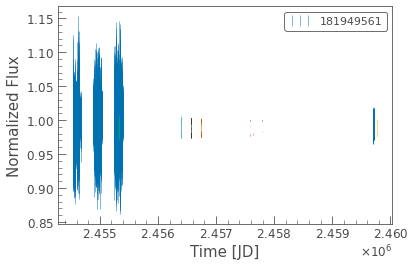

In [5]:
ax = euler_lc.errorbar(ls='')
wasp_lc.errorbar(ax=ax, ls='')
FTN_lc.errorbar(ax=ax, ls='')
ricci_lc.errorbar(ax=ax, ls='')
wfc3_lc.errorbar(ax=ax, ls='')
jwst_lc.errorbar(ax=ax, ls='')
irac1_lc.errorbar(ax=ax, ls='')
irac2_lc.errorbar(ax=ax, ls='')
tess_lc.errorbar(ax=ax, ls='')

In [6]:
flc = wasp_lc.fold(period_est0, t0_est0)
wasp_transit_mask = np.in1d(wasp_lc.time.value, flc.time_original[np.abs(flc.phase.value) < dur_est0 * 2].value)

wasp_y = (wasp_lc[wasp_transit_mask].flux.value - 1)*1e3
wasp_yerr = (wasp_lc[wasp_transit_mask].flux_err.value)*1e3
wasp_x = wasp_lc[wasp_transit_mask].time.jd
a, b = np.unique(np.diff(np.sort(wasp_lc[wasp_transit_mask].time.value)), return_counts=True)
wasp_texp = a[np.argmax(b)]
wasp_sort = np.argsort(wasp_x)

flc = tess_lc.fold(period_est0, t0_est0)
tess_transit_mask = np.in1d(tess_lc.time.value, flc.time_original[np.abs(flc.phase.value) < dur_est0 * 1.5].value)
tess_y = (tess_lc[tess_transit_mask].flux.value - 1)*1e3
tess_yerr = (tess_lc[tess_transit_mask].flux_err.value)*1e3
tess_y /= np.median(tess_lc[~tess_transit_mask].flux.value)
tess_yerr /= np.median(tess_lc[~tess_transit_mask].flux.value)
tess_x = tess_lc[tess_transit_mask].time.jd


datasets = OrderedDict(
    [
        ("WASP", [wasp_x[wasp_sort], wasp_y[wasp_sort], wasp_yerr[wasp_sort], wasp_texp]),
        ("TESS", [tess_x, tess_y, tess_yerr, np.median(np.diff(tess_lc.time.jd.value))]),
        ("Ricci", [ricci_lc.time.jd, (ricci_lc.flux.value - 1)*1e3, (ricci_lc.flux_err.value)*1e3, np.median(np.diff(ricci_lc.time.jd))]),
        ("FTN", [FTN_lc.time.jd, (FTN_lc.flux.value - 1)*1e3, (FTN_lc.flux_err.value)*1e3, np.median(np.diff(FTN_lc.time.jd))]),
        ("Euler", [euler_lc.time.jd, (euler_lc.flux.value - 1)*1e3, (euler_lc.flux_err.value)*1e3, np.median(np.diff(euler_lc.time.jd))]),
        ("HST", [wfc3_lc.time.jd, (wfc3_lc.flux.value - 1)*1e3, (wfc3_lc.flux_err.value)*1e3, np.median(np.diff(wfc3_lc.time.jd))]),
        ("JWST", [jwst_lc.time.jd, (jwst_lc.flux.value - 1)*1e3, (jwst_lc.flux_err.value)*1e3, np.median(jwst_df.texp)]),
        ("IRAC1", [irac1_lc.time.jd, (irac1_lc.flux.value - 1)*1e3, (irac1_lc.flux_err.value)*1e3, np.median(irac1_df.texp)]),
        ("IRAC2", [irac2_lc.time.jd, (irac2_lc.flux.value - 1)*1e3, (irac2_lc.flux_err.value)*1e3, np.median(irac2_df.texp)]),
    ]
)

get_rv_from_df = lambda df, inst: [np.asarray(df['BJD'][df['Inst'] == inst]),
                                   np.asarray(df['RV'][df['Inst'] == inst] - np.median(df['RV'][df['Inst'] == inst])),
                                   np.asarray(df['eRV'][df['Inst'] == inst])
                                  ]
rv_datasets = OrderedDict([
        ("HARPS", get_rv_from_df(rv_df, "HARPSN")),
        ("CORALIE", get_rv_from_df(rv_df, "CORALIE")),
        ("SOPHIE", get_rv_from_df(rv_df, " SOPHIE")),
])

## Find best transit parameter and time estimates

In [7]:
full_lc = lk.LightCurve(*np.vstack([np.vstack([x, y*1e-3 + 1, yerr*1e-3]).T for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items())]).T)
full_lc = full_lc[np.argsort(full_lc.time.value)]
bls = full_lc.normalize().to_periodogram('bls', minimum_period=period_est0*0.99, maximum_period=period_est0*1.01, duration=np.linspace(0.01, 0.1, 100), frequency_factor=10000)
period_est, t0_est, dur_est = bls.period_at_max_power.value, bls.transit_time_at_max_power.value, bls.duration_at_max_power.value

#depth_est = bls.compute_stats(period_est, dur_est, t0_est)['depth'][0].value
depth_est = 0.04
transit_times_est = bls.compute_stats(period_est, dur_est, t0_est)['transit_times'].value
transit_inds_est = np.arange(len(transit_times_est), dtype=int)
transit_times_est, transit_inds_est = np.asarray([(t, ti) for t, ti in zip(transit_times_est, transit_inds_est) if np.any((np.abs(full_lc.time.value - t) * 24) < 3)]).T
transit_times_est = list(transit_times_est)
transit_inds_est = list(transit_inds_est.astype(int))

/Users/ch/.pyenv/versions/3.8.7/lib/python3.8/site-packages/lightkurve/lightcurve.py:277: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


## Plot data

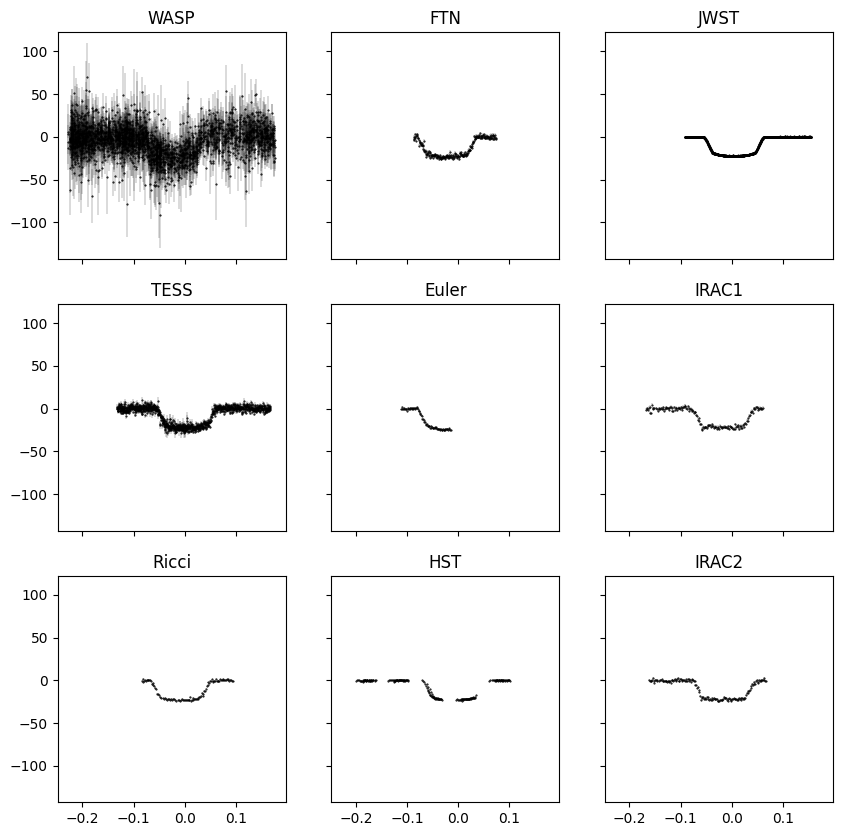

In [8]:
fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    ax[idx, jdx].errorbar(ph, y, yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1)
    ax[idx, jdx].set(title=name)

Text(0.5, 1.0, 'RV Data')

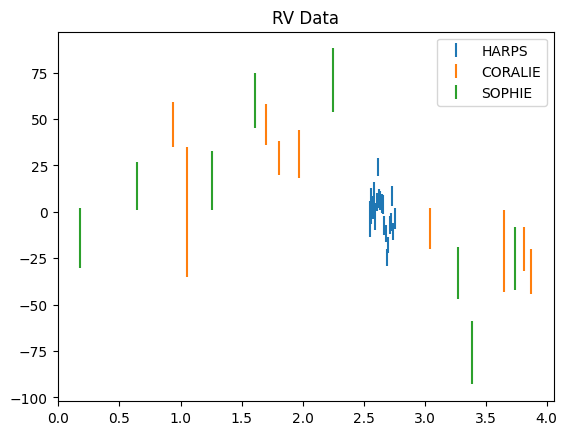

In [9]:
plt.figure()
for n, (name, (x, y, yerr)) in enumerate(rv_datasets.items()):
    plt.errorbar(x % period_est, y, yerr, ls='', label=name)
plt.legend()
plt.title("RV Data")

In [10]:
to_save = ['datasets', 'rv_datasets', 'transit_times_est', 'transit_inds_est', 'period_est', 't0_est', 'dur_est']

In [11]:
r = {obj:globals()[obj] for obj in to_save}

In [12]:
pickle.dump(r, open('data/munged_data.p', 'wb'))